# Predicting cyclist traffic in Paris - EDA

Glenn Louis Opitz, Alexandre Violleau

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

#sns.set_theme()

In [3]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

counter_id              counter_name    site_id  \
48321  100007049-102007049  28 boulevard Diderot E-O  100007049   
48324  100007049-102007049  28 boulevard Diderot E-O  100007049   
48327  100007049-102007049  28 boulevard Diderot E-O  100007049   
48330  100007049-102007049  28 boulevard Diderot E-O  100007049   
48333  100007049-102007049  28 boulevard Diderot E-O  100007049   

                  site_name  bike_count                date  \
48321  28 boulevard Diderot         0.0 2020-09-01 02:00:00   
48324  28 boulevard Diderot         1.0 2020-09-01 03:00:00   
48327  28 boulevard Diderot         0.0 2020-09-01 04:00:00   
48330  28 boulevard Diderot         4.0 2020-09-01 15:00:00   
48333  28 boulevard Diderot         9.0 2020-09-01 18:00:00   

      counter_installation_date         coordinates counter_technical_id  \
48321                2013-01-18  48.846028,2.375429          Y2H15027244   
48324                2013-01-18  48.846028,2.375429          Y2H15027244   
48327                2013-01-18  48.846028,2.375429          Y2H15027244   
48330                2013-01-18  48.846028,2.375429          Y2H15027244   
48333                2013-01-18  48.846028,2.375429          Y2H15027244   

        latitude  longitude  log_bike_count  
48321  48.846028   2.375429        0.000000  
48324  48.846028   2.375429        0.693147  
48327  48.846028   2.375429        0.000000  
48330  48.846028   2.375429        1.609438  
48333  48.846028   2.375429        2.302585

One can observe that the `log_bike_count` column is calculated when applying $ln( \text{bike-count} + 1)$ to the `bike_count` column. The `+1` ensures that the function is still defined for `0`bikes. The idea of taking the natural log is to: 

1. Handle Skewness: Traffic data is ofton skewed with large number of hours with low counts and few hours with high counts. The log reduces the skewness and makes the data more normally distributed.

2. Stabilize variance

3. Better Model Interpretability: Log-transformed predictions allow for proportional interpretations. For example, a small cange in `log_bike_count` corresponds to a percentage change in the actual bike count.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

In [5]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

There are 30 counting sites with sometimes multiple counters per location. 

In [6]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

C:\Users\louis\AppData\Local\Temp\ipykernel_8632\1192055722.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"].sum()


bike_count
site_name                        counter_name                                    
Totem 73 boulevard de Sébastopol Totem 73 boulevard de Sébastopol S-N   1992227.0
Totem 64 Rue de Rivoli           Totem 64 Rue de Rivoli O-E             1551730.0
Totem 73 boulevard de Sébastopol Totem 73 boulevard de Sébastopol N-S   1497912.0
67 boulevard Voltaire SE-NO      67 boulevard Voltaire SE-NO            1130565.0
Totem 64 Rue de Rivoli           Totem 64 Rue de Rivoli E-O             1015875.0
27 quai de la Tournelle          27 quai de la Tournelle SE-NO           984914.0
Quai d'Orsay                     Quai d'Orsay E-O                        948357.0
Totem Cours la Reine             Totem Cours la Reine O-E                894937.0
Face au 48 quai de la marne      Face au 48 quai de la marne SO-NE       884907.0
                                 Face au 48 quai de la marne NE-SO       833657.0

`Totem 73 boulevard de Sébastopol` appears twice on first and third place in terms of bike_counts.

## Visualizing the data 

In [7]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

c:\Users\louis\anaconda3\Lib\site-packages\folium\utilities.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


<Axes: title={'center': 'Bike Count Over Time'}, xlabel='date'>

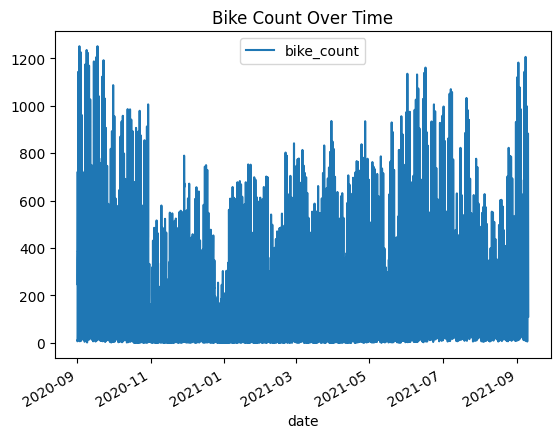

In [8]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

# Aggregate the data
data_mask = data[mask].copy()
data_mask["date"] = pd.to_datetime(data_mask["date"])  # Ensure date is in datetime format
data_agg = data_mask.groupby("date", as_index=False)["bike_count"].sum()

data_agg.plot(x="date", y="bike_count", title="Bike Count Over Time", legend=True)


C:\Users\louis\AppData\Local\Temp\ipykernel_8632\1979972553.py:4: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  pd.Grouper(freq="1w", key="date")


<Axes: xlabel='date'>

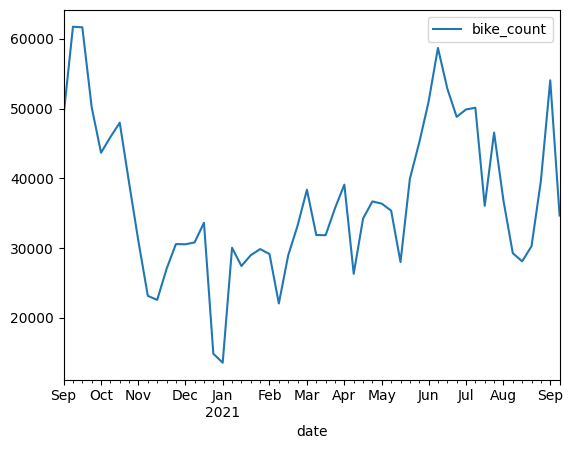

In [9]:
mask = (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")

data[mask].groupby(
    pd.Grouper(freq="1w", key="date")
)[["bike_count"]].sum().plot()

Zooming in one week:

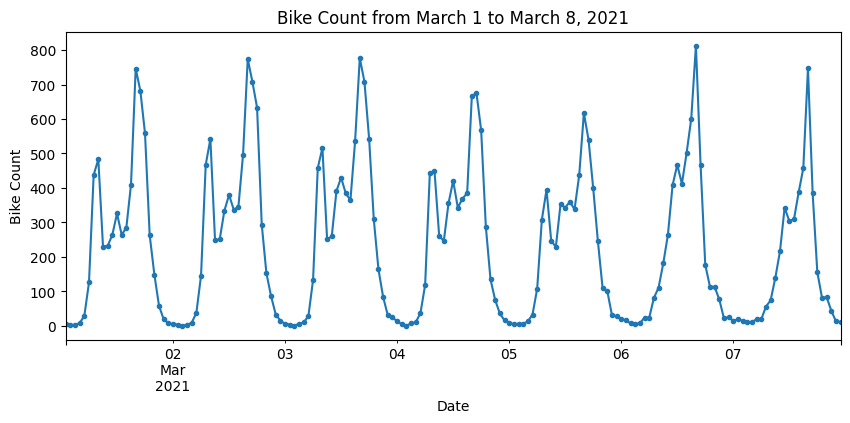

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))

# Filter for the specific counter and date range
mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021-03-01"))
    & (data["date"] < pd.to_datetime("2021-03-08"))
)

# Aggregate data to daily totals (if needed)
data_filtered = data[mask].copy()
data_filtered = data_filtered.groupby("date", as_index=False)["bike_count"].sum()

# Plot the data
data_filtered.plot(x="date", y="bike_count", ax=ax, marker='.', legend=False)
ax.set_title("Bike Count from March 1 to March 8, 2021")
ax.set_ylabel("Bike Count")
ax.set_xlabel("Date")
plt.show()



There appears to be an hourly pattern during workdays with several peaks a day. On weekends, like on 7th and 8th March, the shape of the during the day looks different. In terms of daily peaks, there seem to be slight differences when comparing Monday-Wednesday with Thursday & Friday.

So let us now take a look at all bike counts aggregated on each weekday.

In [ ]:
def _encode_dates(X):
    X = X.copy()  # Ensure we're working on a copy
    # Encode the date information
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday  # 0=Monday, 6=Sunday
    X["hour"] = X["date"].dt.hour
    # Keep the rest of the columns as they are
    return X

# Apply the encoding function to the dataset
data = data.copy()  # Ensure we're working on a copy
data = _encode_dates(data)


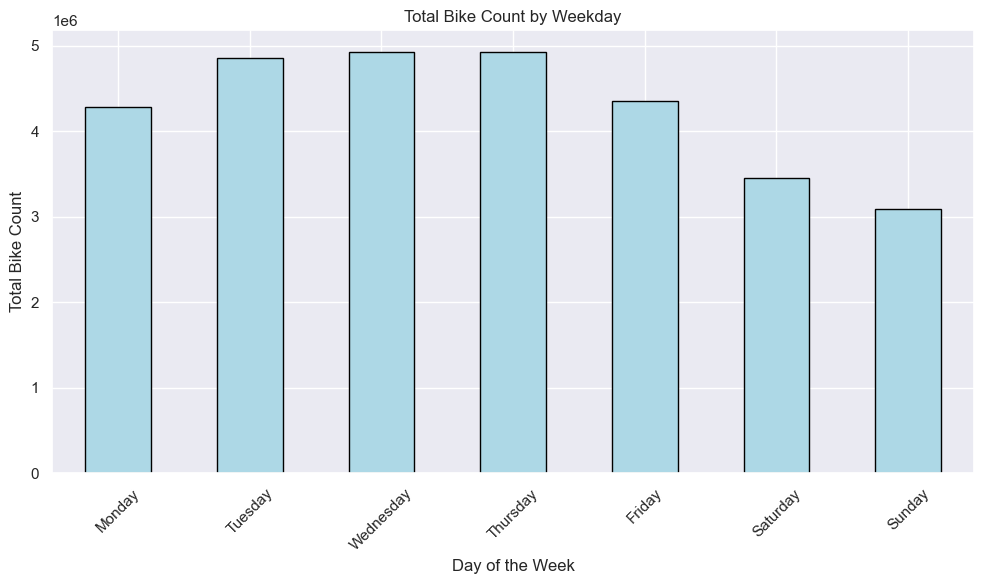

In [ ]:
# Aggregate bike counts by weekday using the encoded 'weekday' column
weekday_aggregates = data.groupby("weekday")["bike_count"].sum()

# Reorder the weekdays to start from Monday (0 = Monday, ..., 6 = Sunday)
weekday_order = [0, 1, 2, 3, 4, 5, 6]
weekday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_aggregates = weekday_aggregates.reindex(weekday_order)

# Plot as a bar chart
plt.figure(figsize=(10, 6))
weekday_aggregates.index = weekday_names  # Replace index with weekday names
weekday_aggregates.plot(kind="bar", color="lightblue", edgecolor="black")
plt.title("Total Bike Count by Weekday")
plt.ylabel("Total Bike Count")
plt.xlabel("Day of the Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see differences among the weekdays on an aggregate level (all counters and along the whole time frame). It would be interesting to see, whether this distribution holds for each counter individually.

C:\Users\louis\AppData\Local\Temp\ipykernel_12176\4289805349.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  station_weekday_counts = data.groupby(["counter_name", "weekday"])["bike_count"].sum().unstack()


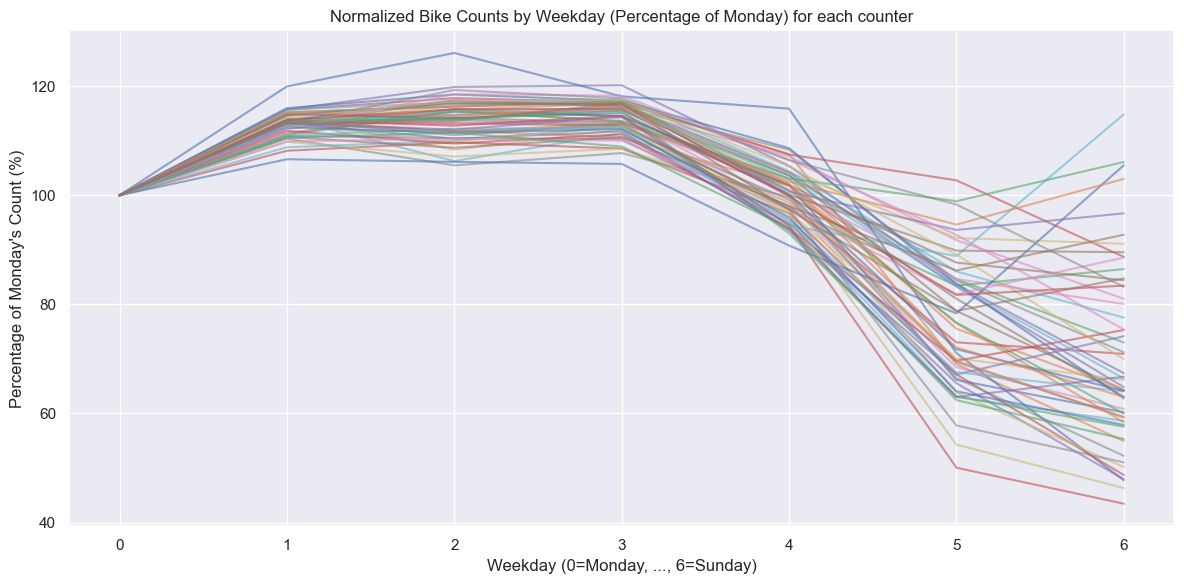

In [ ]:
# Group by station and weekday, summing bike counts
station_weekday_counts = data.groupby(["counter_name", "weekday"])["bike_count"].sum().unstack()

# Normalize counts by Monday (weekday 0)
normalized_counts = station_weekday_counts.div(station_weekday_counts[0], axis=0) * 100

# Plot the normalized distributions for all stations
plt.figure(figsize=(12, 6))
for station in normalized_counts.index:
    plt.plot(normalized_counts.columns, normalized_counts.loc[station], label=station, alpha=0.6)

# Add labels and legend
plt.title("Normalized Bike Counts by Weekday (Percentage of Monday) for each counter")
plt.ylabel("Percentage of Monday's Count (%)")
plt.xlabel("Weekday (0=Monday, ..., 6=Sunday)")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show();

It appears that the rough distribution over weekdays, examined before, holds for all counters. In terms of percentage change against monday (indexed), the weekdays seem most consistent. On weekend days, the variation amongst counters is much higher and may need better investigation.

Maybe it makes sense to group Tuesday until Thursday as one category, given they are all at an equal level in terms of counts.

For least square loss, normal error distributions are beneficial.

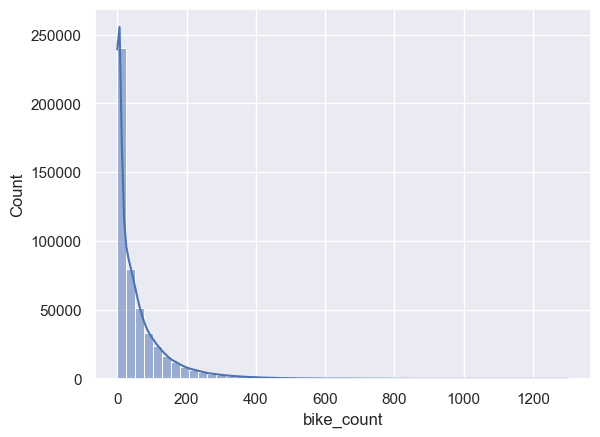

In [ ]:
ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Due to the skewed distribution of `bike_count`, using `log_bike_count` already improves the shape of the distribution, while still not being perfect.

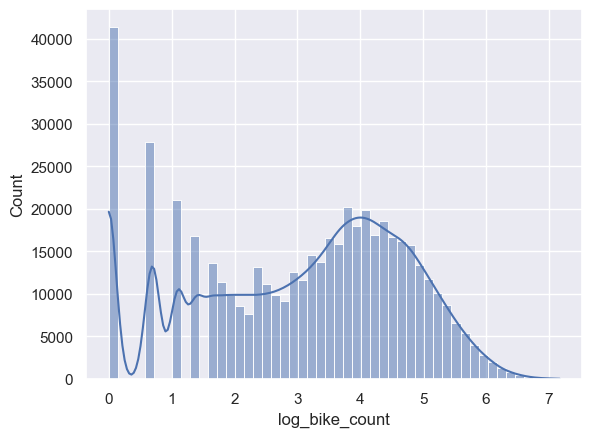

In [ ]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

## Correlation analysis

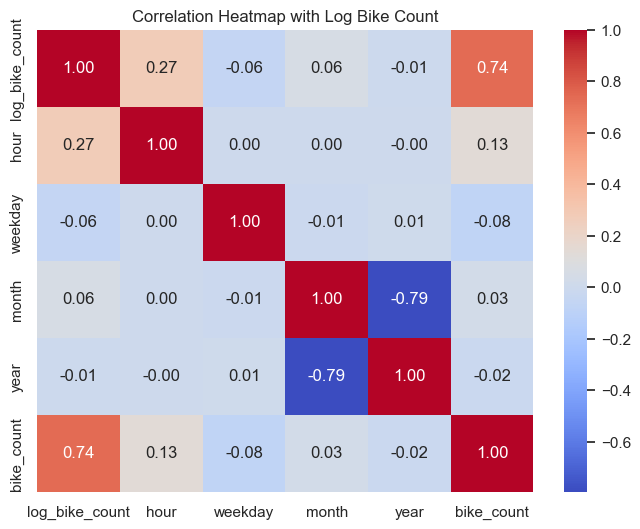

In [ ]:
# Select relevant features for correlation analysis
correlation_features = ["log_bike_count", "hour", "weekday", "month", "year", "bike_count"]

# Compute the correlation matrix
correlation_matrix = data[correlation_features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap with Log Bike Count")
plt.show()

For `log_bike_count`, the strongest correlation can be observed with `hour`, suggesting a deeper analysis on an hourly basis. Presumably, it will make sense to create categorical variables that encode phases of the day (e.g. morning, lunch, afternoon, after-work,...).

In [ ]:
# Define a function to create time-of-day phases
def _add_time_phases(X):
    X = X.copy()  # Work on a copy
    # Create a 'time_of_day' categorical variable
    X["time_of_day"] = pd.cut(
        X["hour"],
        bins=[0, 5, 9, 13, 17, 20, 23],  # Fix the upper boundary to match the bins
        labels=["Night", "Morning", "Midday", "Afternoon", "Evening", "Late Evening"],  # Corresponding labels
        right=True
    )
    return X

# Apply the function to the dataset
data = _add_time_phases(data)

# Preview the new column
print(data[["hour", "time_of_day"]].head())


       hour time_of_day
48321     2       Night
48324     3       Night
48327     4       Night
48330    15   Afternoon
48333    18     Evening


C:\Users\louis\AppData\Local\Temp\ipykernel_12176\3034344149.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_of_day_stats = data.groupby("time_of_day")["log_bike_count"].agg(["mean", "median"]).reset_index()


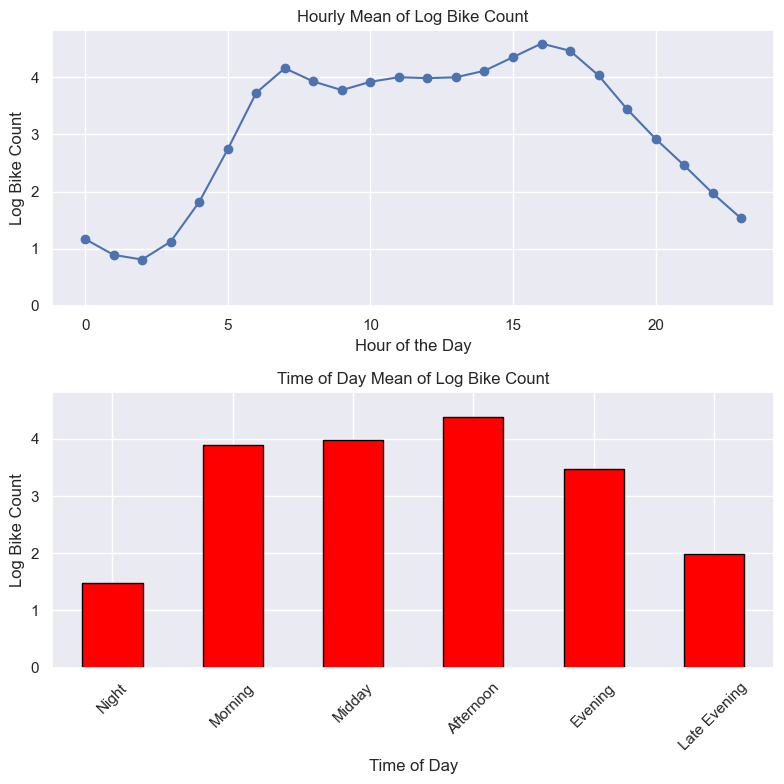

In [ ]:
# Group by 'time_of_day' and calculate mean and median of 'log_bike_count'
time_of_day_stats = data.groupby("time_of_day")["log_bike_count"].agg(["mean", "median"]).reset_index()

# Group by 'hour' and calculate mean 'log_bike_count'
hourly_stats = data.groupby("hour")["log_bike_count"].mean().reset_index()

# Separate the hourly mean and time-of-day mean plots for clarity
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharey=True)

# Plot hourly mean
ax[0].plot(hourly_stats["hour"], hourly_stats["log_bike_count"], label="Hourly Mean", marker="o")
ax[0].set_title("Hourly Mean of Log Bike Count")
ax[0].set_ylabel("Log Bike Count")
ax[0].set_xlabel("Hour of the Day")
ax[0].grid(True)

# Plot time-of-day mean
time_of_day_stats.plot(
    x="time_of_day",
    y="mean",
    kind="bar",
    ax=ax[1],
    color="red",
    legend=False,
    edgecolor="black",
)
ax[1].set_title("Time of Day Mean of Log Bike Count")
ax[1].set_ylabel("Log Bike Count")
ax[1].set_xlabel("Time of Day")
ax[1].set_xticks(range(len(time_of_day_stats["time_of_day"])))
ax[1].set_xticklabels(time_of_day_stats["time_of_day"], rotation=45)

plt.tight_layout()
plt.show()


Observing the hourly mean vs. the mean per day phase shows, that the phases cannot really capture hourly differences. Thus, they might simplify to much and leave out information.

## Adding external weather data

In [ ]:
weather_data = pd.read_csv(Path("data") / "external_data.csv")
print(weather_data.info())
print(weather_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 59 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   numer_sta  3322 non-null   int64  
 1   date       3322 non-null   object 
 2   pmer       3322 non-null   int64  
 3   tend       3322 non-null   int64  
 4   cod_tend   3322 non-null   int64  
 5   dd         3322 non-null   int64  
 6   ff         3322 non-null   float64
 7   t          3322 non-null   float64
 8   td         3322 non-null   float64
 9   u          3322 non-null   int64  
 10  vv         3322 non-null   int64  
 11  ww         3322 non-null   int64  
 12  w1         3315 non-null   float64
 13  w2         3312 non-null   float64
 14  n          3166 non-null   float64
 15  nbas       3317 non-null   float64
 16  hbas       2869 non-null   float64
 17  cl         2909 non-null   float64
 18  cm         1941 non-null   float64
 19  ch         1678 non-null   float64
 20  pres    

In [ ]:
weather_data["date"] = pd.to_datetime(weather_data["date"], errors="coerce")

print(weather_data["date"].isna().sum())

weather_data = _encode_dates(weather_data)



0


In [ ]:
# Merge the datasets
merged_data = pd.merge(data, weather_data, on=["year", "month", "day", "hour"], how="inner")

print(merged_data.head())

            counter_id              counter_name    site_id  \
0  100007049-102007049  28 boulevard Diderot E-O  100007049   
1  100007049-102007049  28 boulevard Diderot E-O  100007049   
2  100007049-102007049  28 boulevard Diderot E-O  100007049   
3  100007049-102007049  28 boulevard Diderot E-O  100007049   
4  100007049-102007049  28 boulevard Diderot E-O  100007049   

              site_name  bike_count              date_x  \
0  28 boulevard Diderot         1.0 2020-09-01 03:00:00   
1  28 boulevard Diderot         4.0 2020-09-01 15:00:00   
2  28 boulevard Diderot         9.0 2020-09-01 18:00:00   
3  28 boulevard Diderot         7.0 2020-09-02 18:00:00   
4  28 boulevard Diderot        12.0 2020-09-03 15:00:00   

  counter_installation_date         coordinates counter_technical_id  \
0                2013-01-18  48.846028,2.375429          Y2H15027244   
1                2013-01-18  48.846028,2.375429          Y2H15027244   
2                2013-01-18  48.846028,2.375429   

In [ ]:
# Check the shape of the merged dataset
print(f"Merged Data Shape: {merged_data.shape}")
print(f"Original Bike Data Shape: {data.shape}")
print(f"Original Weather Data Shape: {weather_data.shape}")


Merged Data Shape: (165368, 78)
Original Bike Data Shape: (496827, 18)
Original Weather Data Shape: (3322, 64)


No proper merge because Bike Data has several rows for the same point in time. For this reason, for EDA, we will aggregate per day:

In [ ]:
aggregated_bike_data = data.groupby("date").agg({
    "bike_count": "sum"  # Sum total bike counts for all counters
}).reset_index()

# Compute the logarithm of the aggregated bike counts
aggregated_bike_data["log_bike_count_aggregated"] = np.log(aggregated_bike_data["bike_count"] + 1)

# Check the resulting aggregated data
print(aggregated_bike_data.head())


                 date  bike_count  log_bike_count_aggregated
0 2020-09-01 01:00:00       147.0                   4.997212
1 2020-09-01 02:00:00       117.0                   4.770685
2 2020-09-01 03:00:00       374.0                   5.926926
3 2020-09-01 04:00:00      1047.0                   6.954639
4 2020-09-01 05:00:00      4595.0                   8.432942


In [ ]:
# Merge weather_data with aggregated bike data
merged_data = pd.merge(aggregated_bike_data, weather_data, on="date", how="inner")

print(f"Merged Data Shape: {merged_data.shape}")
print(f"Aggregated Bike Data Shape: {aggregated_bike_data.shape}")
print(f"Weather Data Shape: {weather_data.shape}")


Merged Data Shape: (2987, 66)
Aggregated Bike Data Shape: (8974, 3)
Weather Data Shape: (3322, 64)


In [ ]:
# Unique timestamps in each dataset
bike_timestamps = set(aggregated_bike_data["date"])
weather_timestamps = set(weather_data["date"])

# Check overlaps
overlap = len(bike_timestamps & weather_timestamps)
print(f"Number of overlapping timestamps: {overlap}")
print(f"Unique timestamps in bike data: {len(bike_timestamps)}")
print(f"Unique timestamps in weather data: {len(weather_timestamps)}")


Number of overlapping timestamps: 2986
Unique timestamps in bike data: 8974
Unique timestamps in weather data: 3321


In [ ]:
# Missing in weather data
missing_in_weather = bike_timestamps - weather_timestamps
print(f"Timestamps in bike data missing from weather data: {len(missing_in_weather)}")

# Missing in bike data
missing_in_bike = weather_timestamps - bike_timestamps
print(f"Timestamps in weather data missing from bike data: {len(missing_in_bike)}")


Timestamps in bike data missing from weather data: 5988
Timestamps in weather data missing from bike data: 335


In [ ]:
# Check the frequency of weather data timestamps
print(weather_data["date"].diff().value_counts())


date
0 days 03:00:00        3305
0 days 06:00:00           4
92 days 03:00:00          2
242 days 03:00:00         1
-386 days +12:00:00       1
91 days 03:00:00          1
31 days 03:00:00          1
-122 days +03:00:00       1
-242 days +03:00:00       1
0 days 00:00:00           1
120 days 03:00:00         1
-61 days +03:00:00        1
-365 days +03:00:00       1
Name: count, dtype: int64


The bike data is hourly while the weather data is every 3 hours. To not loose information in our bike data set, we will resample the weather data to hourly by filling the gaps in the weather data using interpolation.

In [ ]:
# Check for duplicate timestamps in the weather data
duplicate_dates = weather_data["date"].duplicated().sum()
print(f"Number of duplicate timestamps in weather data: {duplicate_dates}")


Number of duplicate timestamps in weather data: 1


In [ ]:
# Get the duplicate timestamps
duplicate_rows = weather_data[weather_data["date"].duplicated(keep=False)]
print(duplicate_rows)


      numer_sta                date    pmer  tend  cod_tend   dd   ff       t  \
2017       7149 2020-11-20 18:00:00  103650    20         2  180  1.0  278.15   
2018       7149 2020-11-20 18:00:00  103650    20         2  180  1.0  278.15   

          td   u  ...  ctype3  hnuage3  nnuage4  ctype4  hnuage4  year  month  \
2017  276.45  89  ...     NaN      NaN      NaN     NaN      NaN  2020     11   
2018  276.45  89  ...     NaN      NaN      NaN     NaN      NaN  2020     11   

      day  weekday  hour  
2017   20        4    18  
2018   20        4    18  

[2 rows x 64 columns]


In [ ]:
# Drop the duplicate row based on the 'date' column
weather_data = weather_data.drop_duplicates(subset="date")

# Verify that the duplicate is removed
duplicate_rows = weather_data[weather_data["date"].duplicated(keep=False)]
print(f"Number of duplicate rows after dropping: {len(duplicate_rows)}")


Number of duplicate rows after dropping: 0


In [ ]:
weather_data.set_index("date", inplace=True)  # Set date as the index
weather_data = weather_data.resample("H").interpolate(method="linear")  # Interpolate missing values
weather_data.reset_index(inplace=True)  # Reset index

# Check the new shape of the weather data
print(f"Resampled Weather Data Shape: {weather_data.shape}")
print(weather_data.head())


Resampled Weather Data Shape: (9973, 64)
                 date  numer_sta           pmer       tend  cod_tend  \
0 2020-09-01 00:00:00     7149.0  102050.000000 -10.000000  8.000000   
1 2020-09-01 01:00:00     7149.0  102030.000000 -26.666667  7.333333   
2 2020-09-01 02:00:00     7149.0  102010.000000 -43.333333  6.666667   
3 2020-09-01 03:00:00     7149.0  101990.000000 -60.000000  6.000000   
4 2020-09-01 04:00:00     7149.0  101993.333333 -36.666667  5.000000   

           dd        ff       t          td          u  ...  ctype3  hnuage3  \
0  340.000000  1.600000  285.75  282.550000  81.000000  ...     NaN      NaN   
1  323.333333  1.433333  285.15  282.383333  83.333333  ...     NaN      NaN   
2  306.666667  1.266667  284.55  282.216667  85.666667  ...     NaN      NaN   
3  290.000000  1.100000  283.95  282.050000  88.000000  ...     NaN      NaN   
4  313.333333  1.333333  284.05  282.316667  89.000000  ...     NaN      NaN   

   nnuage4  ctype4  hnuage4    year  month  d

C:\Users\louis\AppData\Local\Temp\ipykernel_12176\760266445.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_data = weather_data.resample("H").interpolate(method="linear")  # Interpolate missing values


In [ ]:
# Verify the frequency of timestamps after resampling
print(weather_data["date"].diff().value_counts())


date
0 days 01:00:00    9972
Name: count, dtype: int64


In [ ]:
# Update weather timestamps after resampling
weather_timestamps = set(weather_data["date"])

# Recalculate overlap with bike timestamps
overlap = len(bike_timestamps & weather_timestamps)
print(f"Number of overlapping timestamps after resampling: {overlap}")


Number of overlapping timestamps after resampling: 8974


In [ ]:
# Merge the aggregated bike data with the resampled weather data
merged_data = pd.merge(aggregated_bike_data, weather_data, on="date", how="inner")

# Check the shape and preview the merged data
print(f"Merged Data Shape: {merged_data.shape}")
print(merged_data.head())


Merged Data Shape: (8974, 66)
                 date  bike_count  log_bike_count_aggregated  numer_sta  \
0 2020-09-01 01:00:00       147.0                   4.997212     7149.0   
1 2020-09-01 02:00:00       117.0                   4.770685     7149.0   
2 2020-09-01 03:00:00       374.0                   5.926926     7149.0   
3 2020-09-01 04:00:00      1047.0                   6.954639     7149.0   
4 2020-09-01 05:00:00      4595.0                   8.432942     7149.0   

            pmer       tend  cod_tend          dd        ff       t  ...  \
0  102030.000000 -26.666667  7.333333  323.333333  1.433333  285.15  ...   
1  102010.000000 -43.333333  6.666667  306.666667  1.266667  284.55  ...   
2  101990.000000 -60.000000  6.000000  290.000000  1.100000  283.95  ...   
3  101993.333333 -36.666667  5.000000  313.333333  1.333333  284.05  ...   
4  101996.666667 -13.333333  4.000000  336.666667  1.566667  284.15  ...   

   ctype3  hnuage3  nnuage4  ctype4  hnuage4    year  month  d

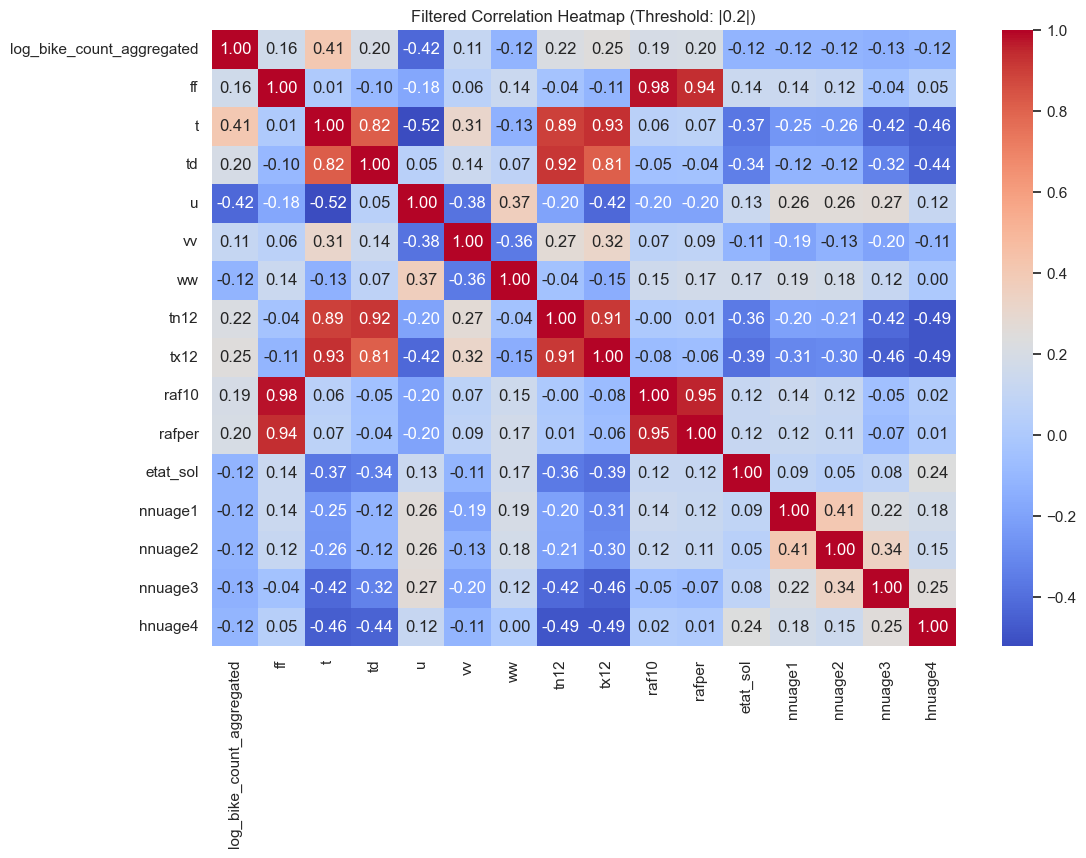

In [ ]:
# Filter correlations for 'log_bike_count_aggregated' greater than the threshold (|0.1|)
threshold = 0.1
correlations = correlation_matrix["log_bike_count_aggregated"].abs()
filtered_variables = correlations[correlations > threshold].index

# Create a filtered correlation matrix
filtered_correlation_matrix = correlation_matrix.loc[filtered_variables, filtered_variables]

# Plot the filtered heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Filtered Correlation Heatmap (Threshold: |0.2|)")
plt.show()


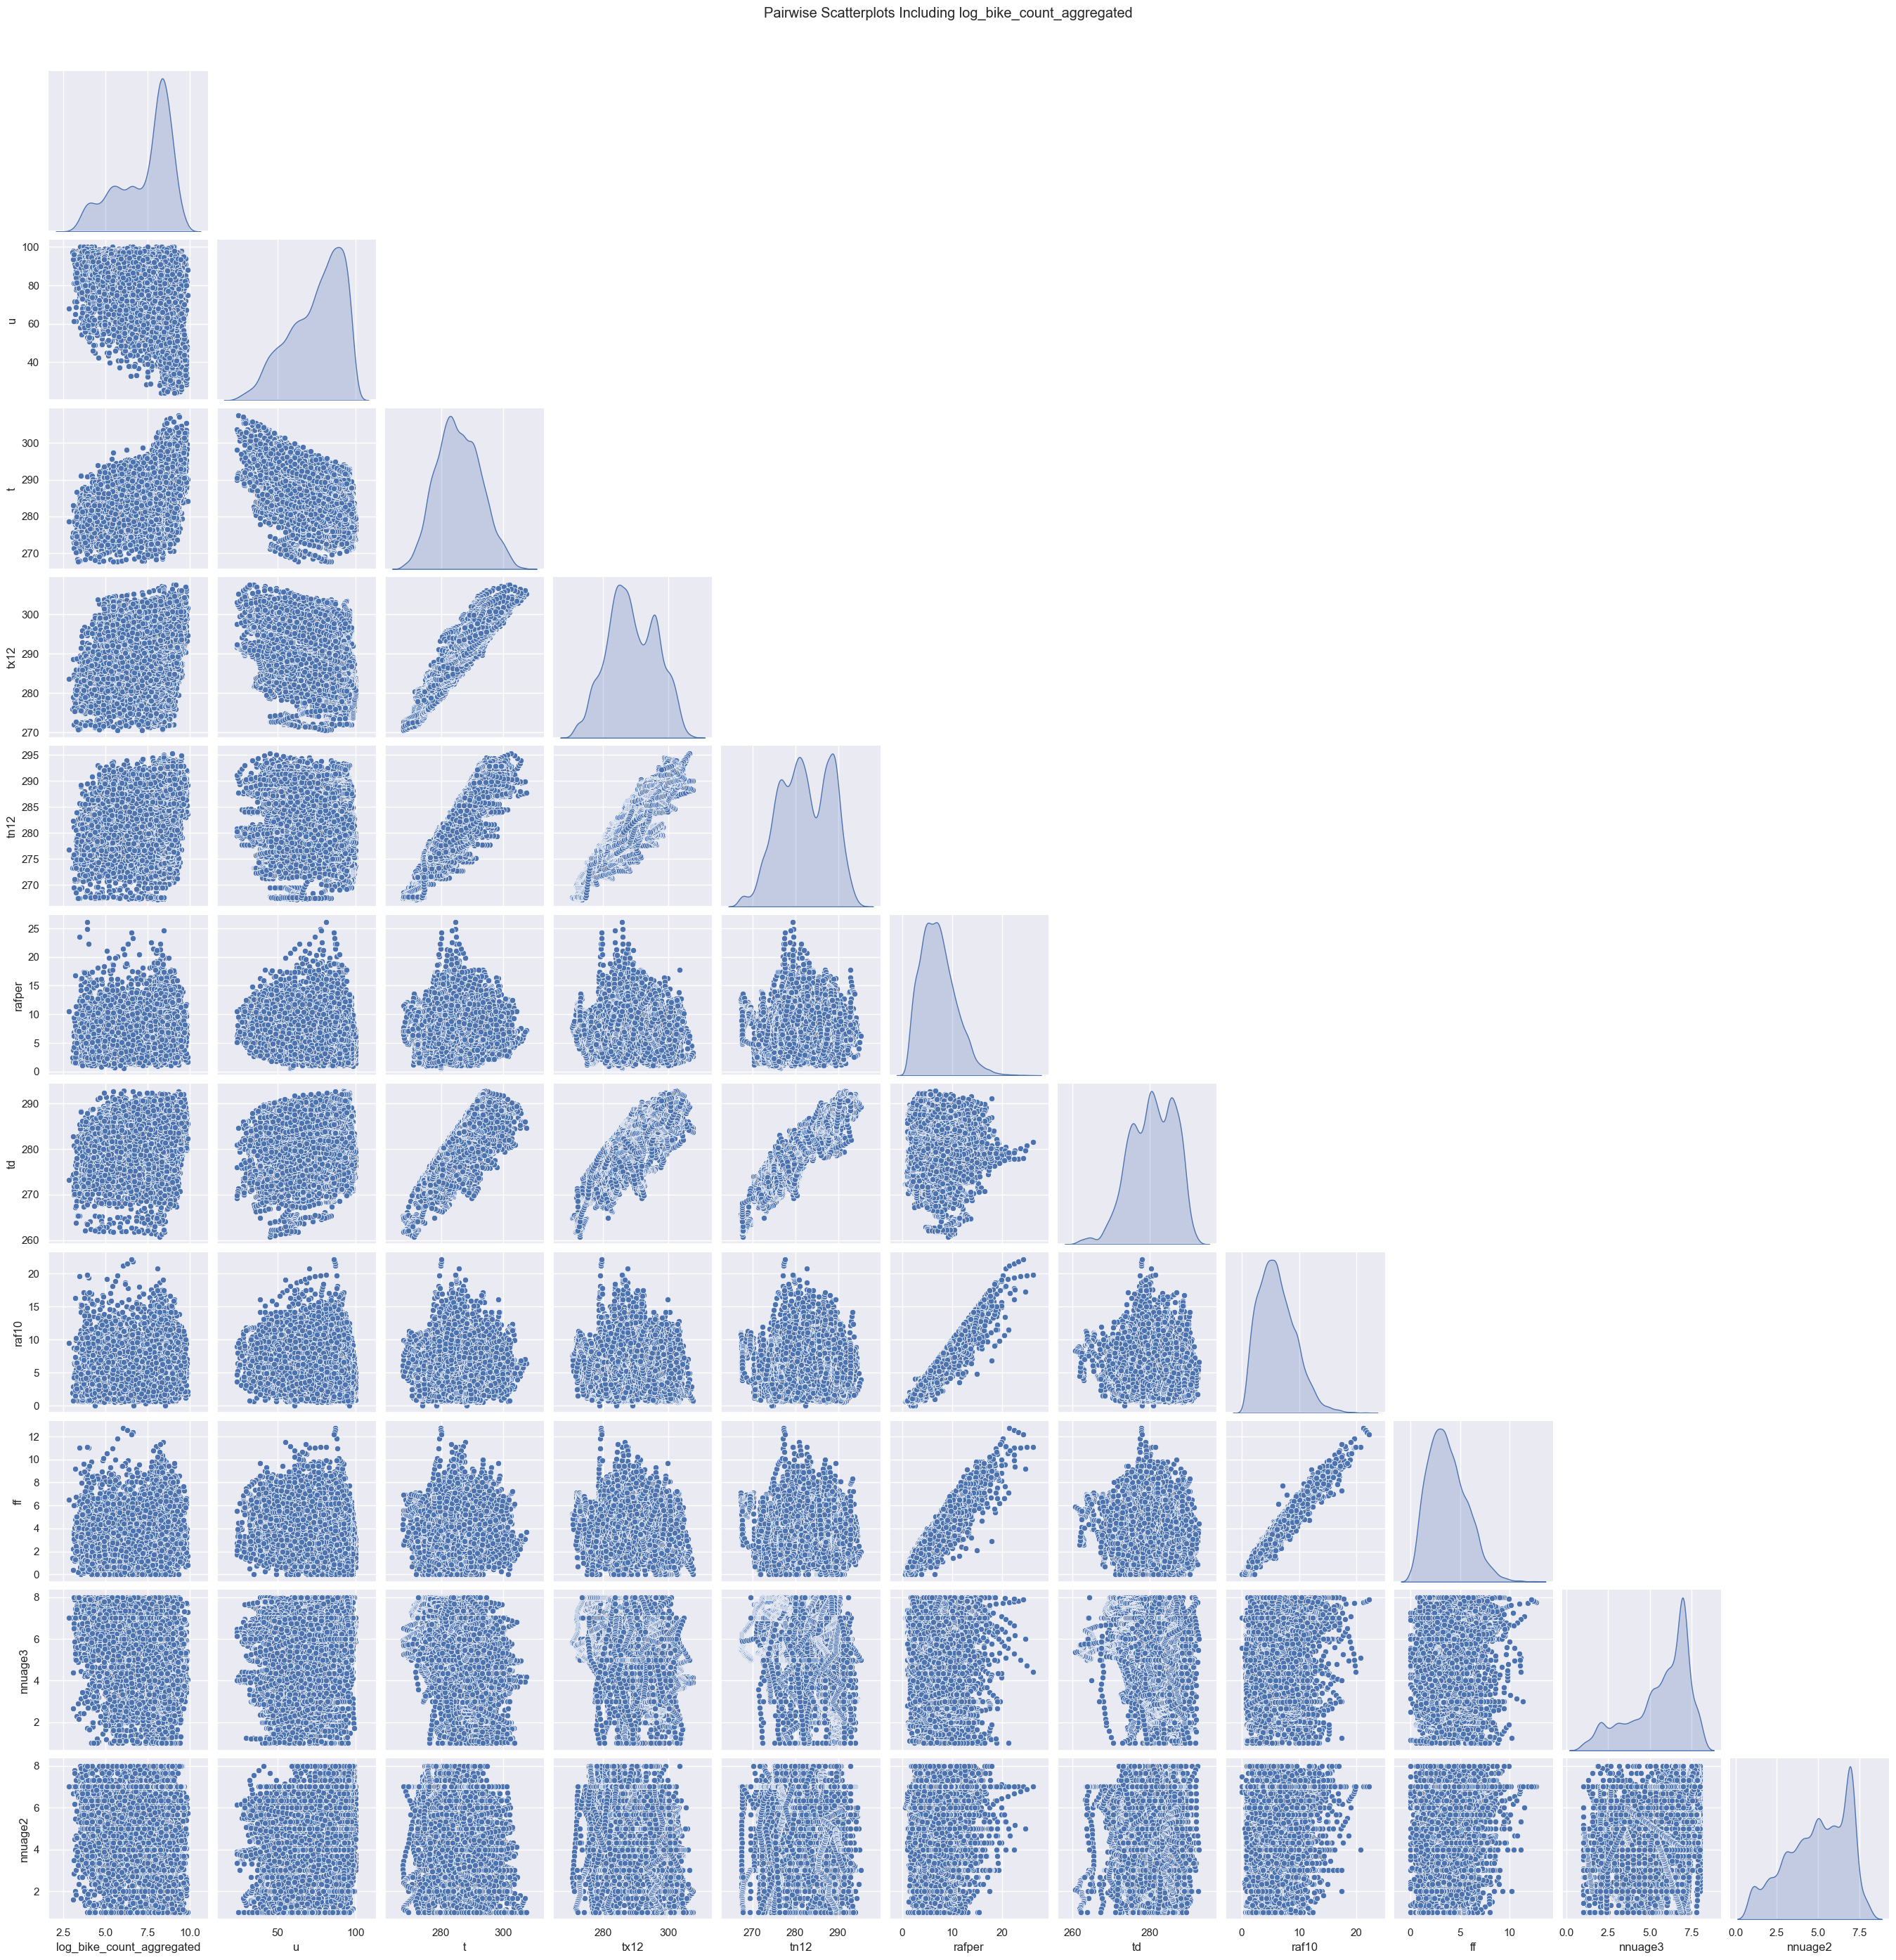

In [ ]:
# Select top N variables by correlation strength
top_variables = correlations.sort_values(ascending=False).index[1:11]  # Top 10 excluding the target

# Include 'log_bike_count_aggregated' in the pairwise plot
top_variables_with_target = ["log_bike_count_aggregated"] + top_variables.tolist()

# Create pairwise scatterplots including the target variable
sns.pairplot(merged_data, vars=top_variables_with_target, diag_kind="kde", kind="scatter", corner=True)
plt.suptitle("Pairwise Scatterplots Including log_bike_count_aggregated", y=1.02)
plt.show()



In [ ]:
correlations.sort_values(ascending=False)

log_bike_count_aggregated    1.000000
u                            0.422441
t                            0.406497
tx12                         0.251181
tn12                         0.217338
rafper                       0.201172
td                           0.196270
raf10                        0.193719
ff                           0.164791
nnuage3                      0.133479
nnuage2                      0.119847
nnuage1                      0.119462
ww                           0.119048
etat_sol                     0.118434
hnuage4                      0.116532
vv                           0.110121
nnuage4                      0.096973
ctype1                       0.072972
rr12                         0.060915
perssfrai                    0.054508
hnuage3                      0.052415
rr24                         0.052234
ctype4                       0.049807
cl                           0.049096
pres                         0.045435
ssfrai                       0.040734
weekday     

The most correlated columns (with correlation coefficient of > |0.1| are:

| Variable  | Description                           | Unit          |
|-----------|---------------------------------------|---------------|
| u         | Humidity                              | %             |
| t         | Temperature                           | K             |
| tx12      | Max. temperature over 12 hours        | K             |
| tn12      | Min. temperature over 12 hours        | K             |
| Rafper    | Bursts over a period                  | m/s           |
| td        | Dew point                             | K             |
| raf10     | Burst over last 10 minutes            | m/s           |
| ff        | Average wind speed over 10 minutes    | m/s           |
| nnuage3   | Cloud cover layer 3                   | octa          |
| nnuage2   | Cloud cover layer 2                   | octa          |
| nnuage1   | Cloud cover layer 1                   | octa          |
| ww        | Present weather condition             | N/A           |
| etat_sol  | Soil condition                        | N/A           |
| hnuage4   | Cloud base height for layer 4         | m             |
| vv        | Horizontal visibility                 | m             |